In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from scipy.optimize import linear_sum_assignment

# load data
lp = '/data2/users/kperks/'
sp = 'ecog_center_out/'
input_file = 'prep_data_lfp_posvel.npy'

data = np.load(lp+input_file, allow_pickle=True)
data = data.item()
ecog = data['lfp']
pose = data['mocap']
recording_day = data['events']
times = data['time']

labels = ecog[:,-1,0]
assert (labels == pose[:,-1,0]).all()
n_targets = len(np.unique(labels))

# load model predictions
rootpth = './xdc_runs/'
dat_type = 'test' # 'train', test'
dataset = 'center_out'
sbjs_all = ['BEIG0414b']
subfolders_d = {'center_out': ['center_out_sup_run10']}
datasets = [dataset]

for i, dst in enumerate(datasets):
    subfolders = subfolders_d[dst]
    for i, fold in enumerate(subfolders):
        for j, sbj in enumerate(sbjs_all):
            fID = rootpth + fold + '/' +sbj + '_preds' + '.npy'
            if os.path.exists(fID):
                print(fID)
                preds_data = np.load(fID,allow_pickle=True).item()
            else:
                preds_data = None
        print(preds_data.keys())

train_inds = preds_data['train_split']
test_inds = preds_data['test_split']
train_true = preds_data['true_train']
train_pred = preds_data['pred_train']
test_true = preds_data['true_test']
test_pred = preds_data['pred_test']
print(len(train_inds), train_true.shape, test_true.shape)

assert train_true.shape[0] == test_true.shape[0]
n_modalities = train_true.shape[0]
assert len(train_inds) == len(test_inds) == train_true.shape[1] == test_true.shape[1]
n_folds = len(train_inds)
print(n_modalities, 'modalities,', n_folds, 'folds')

./xdc_runs/center_out_sup_run10/BEIG0414b_preds.npy
dict_keys(['train_split', 'test_split', 'true_train', 'pred_train', 'true_test', 'pred_test'])
10 (2, 10, 446) (2, 10, 49)
2 modalities, 10 folds


In [11]:
# get matrix of true vs. predicted labels
w_allfolds = np.zeros((n_folds, n_targets, n_targets)) # fold x pred x true

j = 1 # modality [neural, pose]
for i in range(n_folds):
    train_true_curr = train_true[j,i,:]
    train_pred_curr = train_pred[j,i,:]
    test_true_curr = test_true[j,i,:]
    test_pred_curr = test_pred[j,i,:]
    
    ind, D = None, None
    if dat_type == 'train':       
        y_true = np.asarray(train_true_curr)
        y_pred = np.asarray(train_pred_curr) 
        y_true = y_true.astype(np.int64)
        y_pred = y_pred.astype(np.int64)
    elif dat_type == 'test':
        # get train mapping 
        y_true = np.asarray(train_true_curr)
        y_pred = np.asarray(train_pred_curr)
        y_true = y_true.astype(np.int64)
        y_pred = y_pred.astype(np.int64)
        assert y_pred.size == y_true.size
        if not D:
            D = max(y_pred.max(), y_true.max()) + 1
            D = int(D)
        w = np.zeros((D, D), dtype=np.int64)
        for t in range(y_pred.size):
            w[y_pred[t], y_true[t]] += 1
        if not ind:
            ind = linear_sum_assignment(w.max() - w)

        # use train mapping to get test accuracy
        y_true = np.asarray(test_true_curr)
        y_pred = np.asarray(test_pred_curr)
        y_true = y_true.astype(np.int64)
        y_pred = y_pred.astype(np.int64)
    
    assert y_pred.size == y_true.size
    if not D:
        D = max(y_pred.max(), y_true.max()) + 1
        D = int(D)
    w = np.zeros((D, D), dtype=np.int64)
    for t in range(y_pred.size):
        w[y_pred[t], y_true[t]] += 1
    if not ind:
        ind = linear_sum_assignment(w.max() - w)
    print('pred:',ind[0],'true:',ind[1])

    acc = w[ind[0], ind[1]].sum()* 1.0 / y_pred.size
    w_allfolds[i] = w/w.max() # proportion per fold
    # print(acc)
    # print(w)
    # print(ind)
    # print(w[ind[0], ind[1]])

w_avg = w_allfolds.mean(0) # average proportion over folds
print(w_avg)


pred: [0 1 2 3 4 5 6 7] true: [0 1 2 3 4 5 6 7]
pred: [0 1 2 3 4 5 6 7] true: [0 1 2 3 4 5 6 7]
pred: [0 1 2 3 4 5 6 7] true: [0 1 2 3 4 5 6 7]
pred: [0 1 2 3 4 5 6 7] true: [0 1 2 3 4 5 6 7]
pred: [0 1 2 3 4 5 6 7] true: [0 1 2 3 4 5 6 7]
pred: [0 1 2 3 4 5 6 7] true: [0 1 2 3 4 5 6 7]
pred: [0 1 2 3 4 5 6 7] true: [0 1 2 3 4 5 6 7]
pred: [0 1 2 3 4 5 6 7] true: [0 1 2 3 4 5 6 7]
pred: [0 1 2 3 4 5 6 7] true: [0 1 2 3 4 5 6 7]
pred: [0 1 2 3 4 5 6 7] true: [0 1 2 3 4 5 6 7]
[[0.78809524 0.         0.         0.         0.07619048 0.
  0.         0.        ]
 [0.         0.56666667 0.         0.07857143 0.         0.04285714
  0.01428571 0.13571429]
 [0.         0.         0.75238095 0.         0.         0.
  0.21428571 0.        ]
 [0.         0.16666667 0.         0.8047619  0.         0.12142857
  0.01428571 0.01428571]
 [0.12619048 0.         0.         0.         0.84047619 0.
  0.         0.        ]
 [0.         0.06190476 0.         0.         0.         0.4
  0.02857143 0.1  

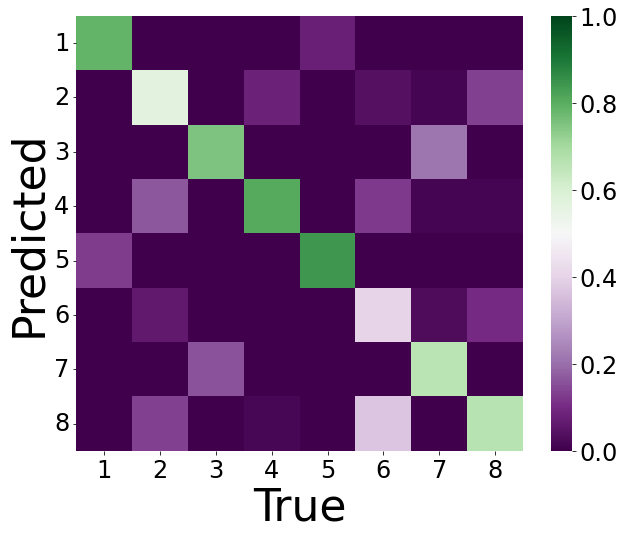

In [12]:
# plot true vs. predicted labels
import seaborn as sns
sz = 24

plt.figure(figsize=(10,8))
ax = sns.heatmap(w_avg, vmin=0, vmax=1, cmap='PRGn')
plt.xlabel('True', fontsize=44)
plt.ylabel('Predicted', fontsize=44)
plt.xticks(np.arange(n_targets)+0.5, range(1,9), fontsize=sz)
plt.yticks(np.arange(n_targets)+0.5, range(1,9), fontsize=sz, rotation=0);
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=sz)
# plt.savefig('xdc_runs/figs/'+subfolders[0][11:]+'_'+dat_type+'_pred_heatmap.png')

In [13]:
# list true vs. predicted labels
for i in range(n_targets):
    print('expected', ind[1][i])
    print('got', train_pred_curr[np.where(train_true_curr == i)])
    print('')

expected 0
got [0. 0. 0. 4. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 0. 0. 4. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]

expected 1
got [1. 1. 1. 1. 1. 7. 3. 1. 1. 1. 1. 1. 1. 1. 3. 1. 3. 1. 1. 3. 1. 1. 1. 1.
 3. 1. 1. 1. 1. 1. 1. 1. 1. 5. 1. 1. 1. 7. 1. 7. 1. 1. 1. 3. 7. 3. 5. 3.
 1. 1. 1. 1. 1. 1. 3. 1.]

expected 2
got [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2.]

expected 3
got [3. 3. 3. 3. 3. 1. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 1.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3.]

expected 4
got [4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 0. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 0. 4.
 4. 4. 4. 4. 4. 4. 4. 4.]

expected 5
got [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.

# Old Code - supervised model only

train acc: 0.7443946188340808
test acc: 0.6938775510204082


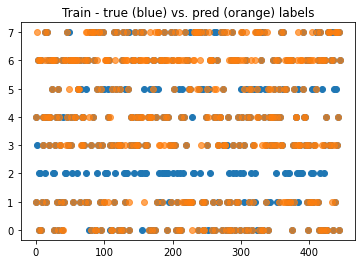

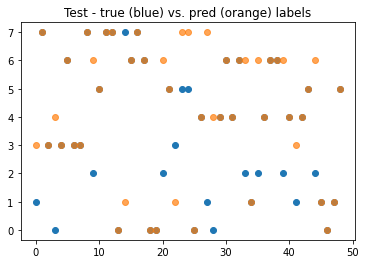

In [7]:
# ONLY WORKS FOR SUPERVISED MODEL WITH 1-1 MAPPING
j = 1 # modality [neural, pose]
i = 0 # fold
train_inds_curr = train_inds[i]
test_inds_curr = test_inds[i]
train_true_curr = train_true[j,i,:]
train_pred_curr = train_pred[j,i,:]
test_true_curr = test_true[j,i,:]
test_pred_curr = test_pred[j,i,:]

print('train acc:', len(np.where(train_true_curr == train_pred_curr)[0])/446)
print('test acc:', len(np.where(test_true_curr == test_pred_curr)[0])/49)

plt.figure()
plt.plot(train_true_curr,'o')
plt.plot(train_pred_curr,'o',alpha=.7)
plt.title('Train - true (blue) vs. pred (orange) labels');

plt.figure()
plt.plot(test_true_curr,'o')
plt.plot(test_pred_curr,'o',alpha=.7)
plt.title('Test - true (blue) vs. pred (orange) labels');

In [8]:
for i in range(n_targets):
    print('expected', i)
    print('got', train_pred_curr[np.where(train_true_curr == i)])
    print('')

expected 0
got [0. 0. 0. 0. 0. 4. 0. 0. 0. 0. 4. 0. 0. 0. 0. 0. 0. 4. 0. 4. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]

expected 1
got [1. 1. 1. 1. 3. 1. 1. 1. 1. 1. 7. 1. 1. 1. 1. 1. 1. 3. 1. 3. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 3. 1. 7. 1. 1. 1. 5. 1. 1. 7. 1. 7. 5. 3. 1. 1. 1. 1.
 1. 3. 1. 1. 1. 1. 1. 1.]

expected 2
got [6. 6. 6. 6. 6. 6. 3. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 3.
 6. 3. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 3. 6. 6. 6. 6. 6. 6. 6.]

expected 3
got [7. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 1. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3.]

expected 4
got [4. 4. 4. 4. 4. 4. 4. 4. 0. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 0. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4.]

expected 5
got [5. 5. 5. 5. 5. 3. 7. 5. 5. 1. 1. 5. 5. 5. 3. 5.

In [9]:
# ONLY WORKS FOR SUPERVISED MODEL WITH 1-1 MAPPING
acc = np.zeros((n_modalities, n_folds, 2)) # n_modalities x n_folds x [train, val]
acc_alt = acc.copy()

for j in range(n_modalities):
    for i in range(n_folds):
        train_true_curr = train_true[j,i,:]
        train_pred_curr = train_pred[j,i,:]
        test_true_curr = test_true[j,i,:]
        test_pred_curr = test_pred[j,i,:]

        # compute accuracy for target (e.g. if true = 1, then pred = 1 is considered accurate)
        acc[j,i,0] = len(np.where(train_true_curr == train_pred_curr)[0]) / 446
        acc[j,i,1] = len(np.where(test_true_curr == test_pred_curr)[0]) / 49

        train_true_alt1 = train_true_curr.copy()
        train_true_alt2 = train_true_curr.copy()
        test_true_alt1 = test_true_curr.copy()
        test_true_alt2 = test_true_curr.copy()
        for t in range(int(n_targets/2)):
            train_true_alt1[np.where(train_true_curr == t + 4)[0]] = t
            train_true_alt2[np.where(train_true_curr == t)[0]] = t + 4
            test_true_alt1[np.where(test_true_curr == t + 4)[0]] = t
            test_true_alt2[np.where(test_true_curr == t)[0]] = t + 4
        
        # compute accuracy for either target or its complement (e.g. if true = 1, then pred = 1 or 5 is considered accurate)
        acc_alt[j,i,0] = (len(np.where(train_true_alt1 == train_pred_curr)[0]) + len(np.where(train_true_alt2 == train_pred_curr)[0])) / 446
        acc_alt[j,i,1] = (len(np.where(test_true_alt1 == test_pred_curr)[0]) + len(np.where(test_true_alt2 == test_pred_curr)[0])) / 49

# [[train ecog, test ecog]
# [train pose, test pose]]
print(acc.mean(1))
print('')
print(acc_alt.mean(1))

[[0.88183857 0.4122449 ]
 [0.81165919 0.74693878]]

[[0.88430493 0.4244898 ]
 [0.89910314 0.84285714]]
